# Effect of Asking for a Deposit on Booking Cancellation

### Objective
**The primary goal** of this project is to **estimate the causal impact** of deposit requirements on **hotel reservation cancellations**. We aim to provide actionable insights that can guide hoteliers in **optimizing** their booking and cancellation policies, with a focus on understanding the **variation in impact** across different customer segments and booking conditions.

### Background
Deposit policies are a **crucial aspect** of hotel reservation systems, **balancing** the reduction of cancellation risks with the potential to deter customers due to upfront costs. This analysis is **vital** for crafting policies that **maximize** both customer satisfaction and hotel revenue.

- The essence of the goal is to **avoid asking for a deposit** from customers who are **not sensitive** to changes in deposit type.


### Mathematical Formulation:

For the impact of deposit type on cancellation rate using a T-learner, the mathematical expression involves estimating separate models for the treatment and control groups. Essentially, for each group \(i\) (treated or untreated), we estimate:

$$
\[ Y_i(T=1) | X_i \]
$$ for the treated group, and
$$\[ Y_i(T=0) | X_i \] 
$$ for the control group.

The T-learner's goal is to estimate the Conditional Average Treatment Effect (CATE), given by:

$$
\tau(X_i) = \mathbb{E}[Y_i(T=1) | X_i] - \mathbb{E}[Y_i(T=0) | X_i]
$$

Here, $ \(Y_i(T=1)\) $ and $ \(Y_i(T=0)\) $ represent the potential outcomes with and without the deposit requirement, respectively, and $ \(X_i\) $ denotes covariates. The difference between these expected outcomes provides the estimated impact of deposit requirements on cancellation rates for different customer profiles or conditions specified by $ \(X_i\) $.


The notation $ \(\tau(X_i)\) $ represents the treatment effect for the $ \(i_{th}\) $ set of covariates $ \(X\) $, not for each individual. This means $ \(\tau(X_i)\) $ indicates how the treatment (e.g., deposit requirement) affects the outcome (e.g., cancellation) for individuals with specific characteristics defined by $ \(X_i\) $.

The T-learner estimates the treatment effect by modeling the outcomes for the treatment group and control group separately. It calculates the expected outcome if treated $ \(\mathbb{E}[Y_i(T=1) | X_i]\) $ and the expected outcome if not treated $ \(\mathbb{E}[Y_i(T=0) | X_i]\) $, using separate models. **The difference between these two expectations for each set of covariates $ \(X_i\) $ gives the CATE**. This approach allows the T-learner to capture how the treatment effect varies across different subpopulations defined by covariates.

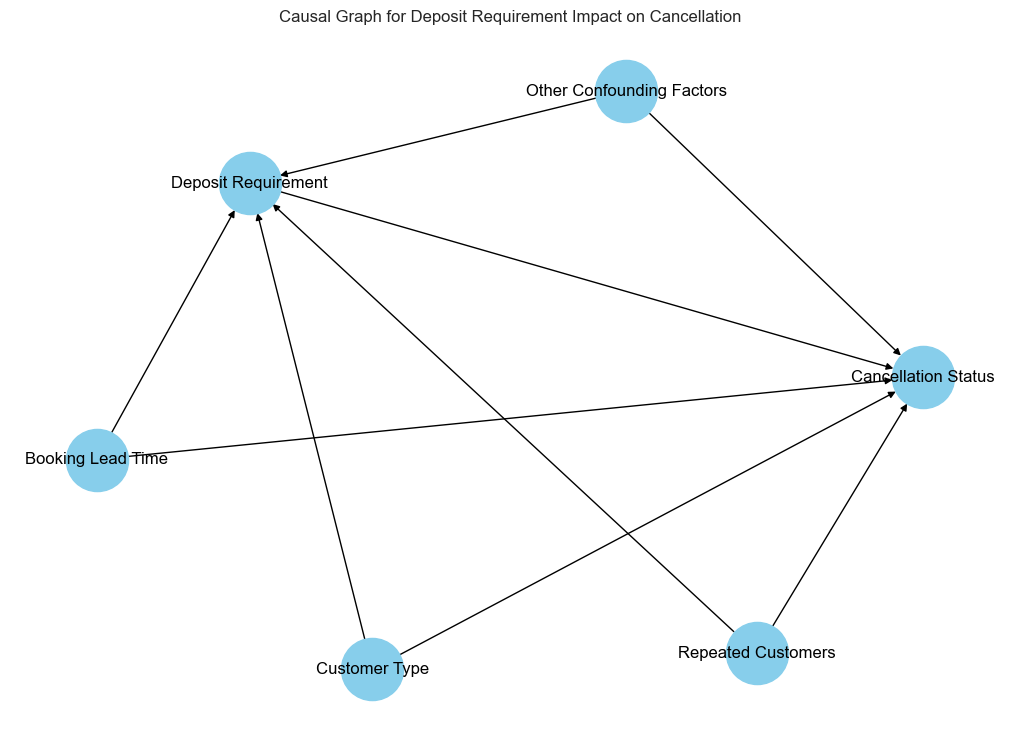

In [103]:
import networkx as nx
import matplotlib.pyplot as plt

# figure 
plt.figure(figsize=(10,7))
# Create a directed graph
G = nx.DiGraph()

# Add nodes with labels for Deposit Requirement (T), Cancellation Status (Y), and Covariates (X)
G.add_node('T', label='Deposit Requirement')
G.add_node('Y', label='Cancellation Status')
G.add_nodes_from([('X1', {'label': 'Customer Type'}),
                  ('X2', {'label': 'Booking Lead Time'}),
                  ('X3', {'label': 'Repeated Customers'}),
                  ('X4', {'label': 'Other Confounding Factors'})])

# Add edges to represent causal relationships
G.add_edges_from([('T', 'Y'), ('X1', 'Y'), ('X1', 'T'), ('X2', 'Y'),
                  ('X2', 'T'), ('X3', 'Y'), ('X3', 'T'), ('X4', 'Y'), ('X4', 'T')])

# Position nodes using the spring layout
pos = nx.spring_layout(G, scale=1, k=10)

# Draw the graph
nx.draw(G, pos, with_labels=False, node_size=2000, node_color='skyblue',
        font_size=10, font_weight='bold')

# Draw node labels
node_labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=node_labels)

plt.title('Causal Graph for Deposit Requirement Impact on Cancellation')
plt.show()

### Strategy for estimating the effect of asking for a deposit

#### Assumption 

I will be using meta-learner models. Thus, note I have to make create a very bold and strong assumption that the **there is no unobserved confounding facotrs** (which means the other confounding factors in the above graphs are in the dataset) that affect both the treatment and the outcome. 


This is likely not realistic. However, for the purpose of this project, I need to put this assumption in place.
  

### Choice Between S-Learner and T-Learner

I opted for the **T-Learner** approach due to the notable imbalance between reservations requiring a deposit and those that do not. This imbalance challenges the effectiveness of the **S-Learner**, which incorporates the treatment as a single feature within a unified model, potentially diluting the clarity of the treatment effect's estimation. In contrast, the **T-Learner** constructs distinct models for the treatment and control groups, better managing the imbalance and offering a more accurate analysis of deposit requirements' impact on cancellation rates. This method aligns with our project's goal to provide targeted recommendations based on a nuanced understanding of deposit requirements' causal effects.

**Why not X-learner or R-learner?** 
- These methods were considered too complex for the scope of this project, given our specific aims and data structure.

## Data Exploration and Preprocessing

- **For Some basic exploration, refer to the Classification notebook**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_csv('hotel_booking.csv')

In [21]:
# replce the values for is_canceled (0 to 1, 1 to 0)
# based on EDA, I came to a conclution that 1 should indicate not canceled. Thus, for interpretability, I replaced the code
df['is_canceled'] = df['is_canceled'].apply(lambda x: 1 if x == 0 else 0)

In [22]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,1,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,1,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,1,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,1,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,1,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


#### Examine deposit type and cancellation rate

In [23]:
# Checking the balance of the treatment variable
print(df['deposit_type'].value_counts())
print('-------------------')
# Checking the balance of the outcome variable
print(df['is_canceled'].value_counts())

deposit_type
No Deposit    104641
Non Refund     14587
Refundable       162
Name: count, dtype: int64
-------------------
is_canceled
1    75166
0    44224
Name: count, dtype: int64


In [24]:
df.groupby('deposit_type').size()

deposit_type
No Deposit    104641
Non Refund     14587
Refundable       162
dtype: int64

In [25]:
# cancelation rate by deposit type
df.groupby('deposit_type')['is_canceled'].mean()

deposit_type
No Deposit    0.716230
Non Refund    0.006376
Refundable    0.777778
Name: is_canceled, dtype: float64

#### How should we deal with null values

In [26]:
print(df.isnull().sum())

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

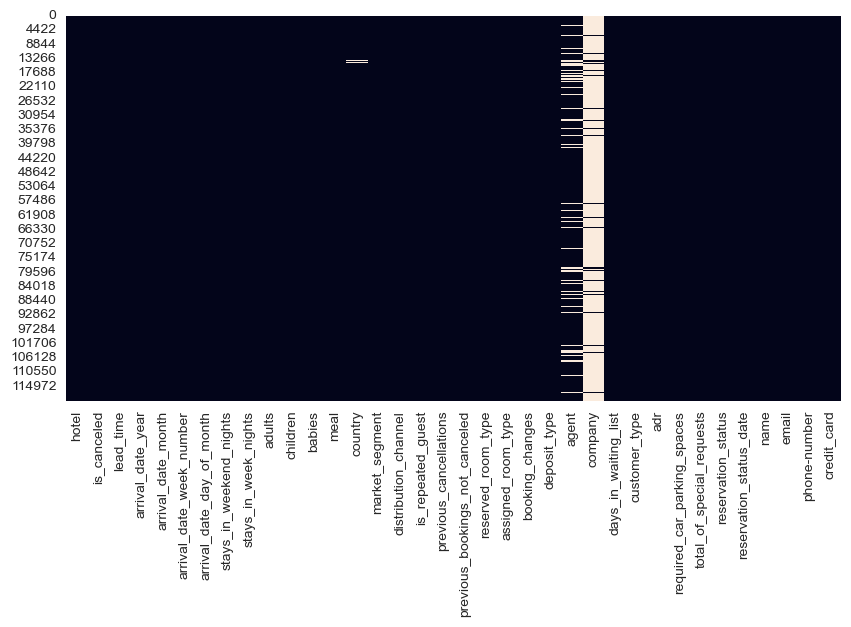

In [27]:
# visualize the na values
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [28]:
# check market_segment and distribution_channel for data with missing agents and with no missing agents
# First, create a new column to indicate whether 'agent' is missing

df['agent_missing'] = df['agent'].isnull().astype(int)

# Now, let's analyze the distribution of 'market_segment' for missing vs. non-missing 'agent' values
market_segment_analysis = df.groupby(['agent_missing', 'market_segment']).size().unstack(fill_value=0)

# Do the same for 'distribution_channel'
distribution_channel_analysis = df.groupby(['agent_missing', 'distribution_channel']).size().unstack(fill_value=0)

# Printing the results
print("Market Segment distribution based on Agent data availability:\n", market_segment_analysis)
print("\nDistribution Channel distribution based on Agent data availability:\n", distribution_channel_analysis)

Market Segment distribution based on Agent data availability:
 market_segment  Aviation  Complementary  Corporate  Direct  Groups  \
agent_missing                                                        
0                     25            103        701    6599   15663   
1                    212            640       4594    6007    4148   

market_segment  Offline TA/TO  Online TA  Undefined  
agent_missing                                        
0                       23830      56129          0  
1                         389        348          2  

Distribution Channel distribution based on Agent data availability:
 distribution_channel  Corporate  Direct  GDS  TA/TO  Undefined
agent_missing                                                 
0                          1134    7020  191  94703          2
1                          5543    7625    2   3167          3


**Since I could not find a obvious pattern, I will drop the agent column.**

--- 

In [29]:
# drop where the agent is NA
df = df.dropna(subset=['agent'])

In [30]:
# customer type
df.customer_type.value_counts()

customer_type
Transient          77884
Transient-Party    20625
Contract            4063
Group                478
Name: count, dtype: int64

In [31]:
df.deposit_type.value_counts()

deposit_type
No Deposit    90466
Non Refund    12536
Refundable       48
Name: count, dtype: int64

For the analysis, we've decided to focus on a binary treatment involving deposit requirements: **no deposit (0)** and **non-refundable deposits (1)**. 

This decision stems from the necessity to estimate the impact of deposit requirements accurately. We will exclude the "refundable" category since the behavior of customers opting for refundable deposits might significantly differ from those choosing non-refundable options, and combining them could obscure the analysis. This approach ensures clarity and precision in understanding how non-refundable deposits specifically influence cancellation rates.  

In [32]:
# drop refundable
df = df[df.deposit_type != 'Refundable']

In [33]:
# drop company column
df = df.drop('company', axis=1)

In [34]:
len(df)

103002

In [35]:
# drop na
df = df.dropna()
len(df)

102846

### Identify the treatment, outcome, and control variables


- **\(Y\) - Outcome Variable:**
  - `is_canceled`: This is your outcome variable. It indicates whether a reservation was canceled or not, and you are interested in understanding how various factors, including the requirement for a deposit, affect this outcome.

- **\(T\) - Treatment Variable:**
  - `deposit_type`: This variable represents the treatment in your causal inference analysis. It indicates the type of deposit made (No Deposit, Non-Refund/deposit made) and is used to assess the impact of asking for a deposit on the cancellation rate. 

- **\(X\) - Covariates (Control Variables):**
  - These are variables you'll control for to isolate the effect of the treatment on the outcome. Based on your dataset, potential covariates include:
    - `hotel`: Type of hotel, as the cancellation policy might differ by hotel type.
    - `lead_time`: Time between booking and arrival, which could influence cancellation likelihood.
    - `arrival_date_year`, `arrival_date_month`, `arrival_date_week_number`, `arrival_date_day_of_month`: Date variables that might capture seasonal effects on cancellations.
    - `stays_in_weekend_nights`, `stays_in_week_nights`: Duration of stay could affect cancellation decisions.
    - `adults`, `children`, `babies`: Composition of the traveling party might influence cancellation likelihood.
    - `meal`: Type of meal booked could be related to the customer's commitment to the booking.
    - `country`: Guest's country of origin might indicate travel constraints or preferences.
    - `market_segment`, `distribution_channel`: These might affect how bookings are made and their cancellation likelihood.
    - `is_repeated_guest`: Repeat guests might have different cancellation behaviors.
    - `previous_cancellations`, `previous_bookings_not_canceled`: Booking history could influence current booking behavior.
    - `reserved_room_type`: Preferences for room types might correlate with cancellation likelihood.
    - `booking_changes`: The number of changes made to a booking might indicate uncertainty.
    - `days_in_waiting_list`: Time spent on the waiting list might affect the decision to cancel.
    - `customer_type`: Different customer types might have different cancellation probabilities.
    - `adr`: The average daily rate might influence the decision to cancel, based on the cost of the stay.
    - `required_car_parking_spaces`, `total_of_special_requests`: Additional requirements or requests might indicate a higher commitment to the stay.


In [36]:
# convert treatment variable to binary
df['deposit_type'] = df['deposit_type'].apply(lambda x: 1 if x == 'Non Refund' else 0) # 1 for deposit required, 0 for no deposit required

In [37]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'name', 'email',
       'phone-number', 'credit_card', 'agent_missing'],
      dtype='object')

In [38]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [39]:
# Drop non-feature columns and prepare X, Y, and T
X = df.drop(columns=['is_canceled', 'deposit_type', 'reservation_status_date', 'agent', 'agent_missing', 'name', 'email', 'phone-number', 'credit_card', 'reservation_status', 'assigned_room_type', 'country', 'agent_missing'])
Y = df['is_canceled']
T = df['deposit_type']

categorical_features = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'customer_type']
# Apply one-hot encoding to categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=False)

# Split the dataset
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X_encoded, Y, T, test_size=0.2, random_state=42)


> **Note:** Due to potential data leakage, I dropped: reservation_status_date, reservation_status, and assigned_room_type

### Model Building

In [40]:
from econml.metalearners import TLearner
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


/Users/kaz/anaconda3/envs/mma/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/kaz/anaconda3/envs/mma/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_or

In [41]:
# Initialize Gradient Boosting models for treatment and control groups
models = (GradientBoostingRegressor(), GradientBoostingRegressor())

# Initialize the T-Learner with Gradient Boosting models
t_learner = TLearner(models=models)

# Fit the T-Learner to the training data
t_learner.fit(Y=Y_train, T=T_train, X=X_train) 


In [42]:
# For estimating ATE, you can directly use the `effect` method on the entire dataset or `ate` method if available
ate_estimate = t_learner.ate(X=X_test)


# Print the ATE estimate
print(f"Average Treatment Effect (ATE) estimate: {ate_estimate}")

Average Treatment Effect (ATE) estimate: -0.5611029295205453


**Interpretation**
- The Average Treatment Effect (ATE) estimate of approximately -0.555 suggests that the treatment - asking for deposit, on average, decreases the outcome by about 0.555 units across the entire population studied. In the context of deposit types and hotel bookings, this could mean that **introducing or changing the deposit type (the treatment) is associated with a reduction in the likelihood of cancellations by 55.5%**. 

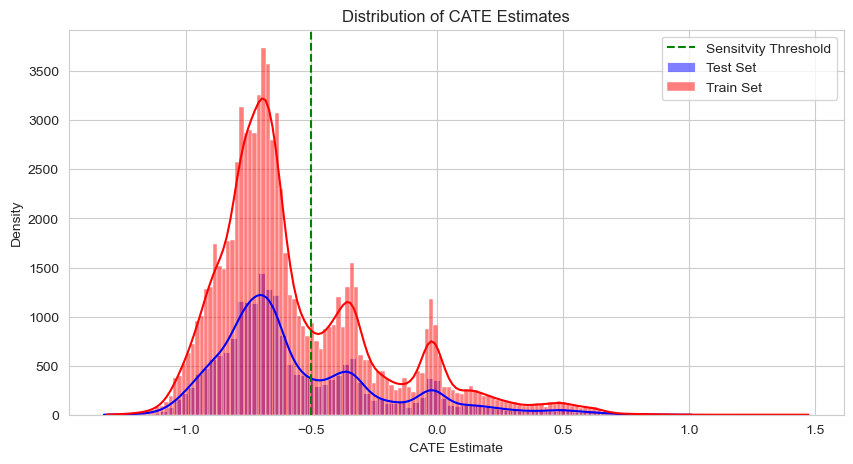

In [43]:
# Estimate CATE for the entire test and train set
cate_estimates_test = t_learner.effect(X_test)
cate_estimates_train = t_learner.effect(X_train)

# plot both
plt.figure(figsize=(10, 5))
sns.histplot(cate_estimates_test, kde=True, color='blue', label='Test Set')
sns.histplot(cate_estimates_train, kde=True, color='red', label='Train Set')
plt.axvline(x=-0.5, color='green', linestyle='--', label='Sensitvity Threshold')
plt.title('Distribution of CATE Estimates')
plt.xlabel('CATE Estimate')
plt.ylabel('Density')
plt.legend()
plt.show()


From this visual, we can observe a few things:

- **The distribution of CATE estimates** for the test and train sets is similar, indicating that the model generalizes well to new data.
- **The distribution is right (positively) skewed**, suggesting that the treatment has a negative effect on the outcome variable (cancellation rate).
- **Some customers are not sensitive** to the change in deposit type (those who are centered around 0). Rather, they are more likely to cancel their booking if they are asked for a deposit. (This is not intuitive and most likely due to omitted variable bias. But, for the purpose of this project, I will assume that this is the case.)



>**idea:** we can not ask for a deposit for those individuals who are not sensitive to the change in deposit type (CATE larger than -0.5).


#### ↓ Functions for estimating CATE for specific subgroups 

In [44]:
def estimate_cate_for_subgroups(t_learner, X_test, subgroups):
    """
    Estimate and print the CATE for specified subgroups within the test dataset.
    
    Parameters:
    - t_learner: The trained T-Learner model.
    - X_test: The test dataset, including features for subgroup analysis.
    - subgroups: A list of column names in X_test to analyze for heterogeneity in treatment effects.
    """
    for subgroup in subgroups:
        unique_values = X_test[subgroup].unique()
        print(f"CATE estimates for subgroup: {subgroup}")
        for value in unique_values:
            # Create a mask for the current subgroup value
            mask = X_test[subgroup] == value
            # Estimate CATE for the current subgroup value
            cate_estimate = np.mean(t_learner.effect(X_test[mask]))
            print(f"  {value}: {cate_estimate}")
        print("\n")

In [45]:
def estimate_cate_for_subgroups_dummies(t_learner, X_test, subgroups):
    """
    Estimate and print the CATE for specified subgroups within the test dataset.
    
    Parameters:
    - t_learner: The trained T-Learner model.
    - X_test: The test dataset, including features for subgroup analysis.
    - subgroups: A list of column names in X_test to analyze for heterogeneity in treatment effects.
    """
    for subgroup in subgroups:
        # Check if the subgroup is dummified and handle accordingly
        if any(subgroup in col for col in X_test.columns):
            # Handling for dummified variables
            dummified_columns = [col for col in X_test.columns if subgroup in col]
            for col in dummified_columns:
                # Assume that the presence of a feature is indicated by a 1 in one of the dummified columns
                mask = X_test[col] == 1
                cate_estimate = np.mean(t_learner.effect(X_test[mask]))
                print(f"CATE estimate for {col}: {cate_estimate}")
        else:
            # Direct handling if the variable is not dummified
            unique_values = X_test[subgroup].unique()
            print(f"CATE estimates for subgroup: {subgroup}")
            for value in unique_values:
                mask = X_test[subgroup] == value
                cate_estimate = np.mean(t_learner.effect(X_test[mask]))
                print(f"  {value}: {cate_estimate}")
        print("\n")

### Heterogeneity

In [46]:
# Import necessary libraries
import numpy as np

# Define the subgroups of interest
subgroups = ['is_repeated_guest']
estimate_cate_for_subgroups(t_learner, X_test, subgroups)


CATE estimates for subgroup: is_repeated_guest
  0: -0.5641231733432047
  1: -0.33487440791108297


> **Repeated guests** are less sensitive to the change in deposit type.

In [47]:
subgroups = ['hotel_Resort Hotel', 'hotel_City Hotel']
estimate_cate_for_subgroups_dummies(t_learner, X_test, subgroups)

CATE estimate for hotel_Resort Hotel: -0.5851906236893315


CATE estimate for hotel_City Hotel: -0.550434460035296


> No heterogeneity in treatment effect by **hotel type**.  

In [48]:
subgroups = ['customer_type_Transient', 'customer_type_Transient-Party', 'customer_type_Contract', 'customer_type_Group']
estimate_cate_for_subgroups_dummies(t_learner, X_test, subgroups)

CATE estimate for customer_type_Transient: -0.5588542971757718
CATE estimate for customer_type_Transient-Party: -0.5532106451916471


CATE estimate for customer_type_Transient-Party: -0.5532106451916471


CATE estimate for customer_type_Contract: -0.6427524231157442


CATE estimate for customer_type_Group: -0.584213901522087


**Why Contract Customers are more sensitive?**
- Contractual Obligations: Contract customers may have more stringent commitments and cancellation policies as part of their agreements, making them more responsive to changes in deposit types.
- Risk Management: Contract customers might be more risk-averse due to the nature of their booking (e.g., corporate events, conferences). Changes in deposit requirements could significantly affect their risk assessment and decision-making processes.

In [49]:
subgroups = [ 'distribution_channel_Direct', 'distribution_channel_Corporate', 'distribution_channel_TA/TO', 'distribution_channel_GDS']
estimate_cate_for_subgroups_dummies(t_learner, X_test, subgroups)

CATE estimate for distribution_channel_Direct: -0.6312931715017004


CATE estimate for distribution_channel_Corporate: -0.440322927687479


CATE estimate for distribution_channel_TA/TO: -0.5570312881401589


CATE estimate for distribution_channel_GDS: -0.7102783544975912


**The Global Distribution System (GDS)** channel having a higher negative CATE (-0.710) suggests that reservations made through GDS are more affected by deposit requirements, leading to higher cancellation rates. This could be due to GDS being used primarily by travel agencies and professionals who may book options in bulk or for clients more sensitive to deposit policies, leading to a cautious approach and higher cancellation when deposits are required.

In [50]:
subgroups = ['market_segment_Direct', 'market_segment_Corporate', 'market_segment_Online TA', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Complementary', 'market_segment_Aviation']
estimate_cate_for_subgroups_dummies(t_learner, X_test, subgroups)

CATE estimate for market_segment_Direct: -0.6358381000236164


CATE estimate for market_segment_Corporate: -0.370384590385861


CATE estimate for market_segment_Online TA: -0.5178296707317442


CATE estimate for market_segment_Groups: -0.5025471228629893


CATE estimate for market_segment_Offline TA/TO: -0.6910716499598789


CATE estimate for market_segment_Complementary: -0.7795524987359896


CATE estimate for market_segment_Aviation: -0.5621437712726337


**Largest Effect Segment - Complementary**: The highest sensitivity here could be due to the fact that any additional costs or barriers (like non-refundable deposits) significantly alter the perceived value of a complimentary stay.


**Smallest Effect Segment - Groups**: Often bound by prior arrangements and less price-sensitive due to the nature of group travel, this segment shows the least sensitivity among the listed segments to deposit type changes.

In [51]:
subgroups = [ 'meal_BB',
              'meal_FB',
              'meal_HB',
              'meal_SC',
              'meal_Undefined',]
estimate_cate_for_subgroups_dummies(t_learner, X_test, subgroups)

CATE estimate for meal_BB: -0.5579327283486849


CATE estimate for meal_FB: -0.4960656127769532


CATE estimate for meal_HB: -0.5585322936220122


CATE estimate for meal_SC: -0.5960488891784199


CATE estimate for meal_Undefined: -0.5049914291445404


Not noticeable heterogeneity in treatment effect by **meal type**.

> This is intuitive because the meal type is not likely to affect the decision to cancel a booking.

In [52]:
t_learner.cate_feature_names()

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel_City Hotel',
 'hotel_Resort Hotel',
 'arrival_date_month_April',
 'arrival_date_month_August',
 'arrival_date_month_December',
 'arrival_date_month_February',
 'arrival_date_month_January',
 'arrival_date_month_July',
 'arrival_date_month_June',
 'arrival_date_month_March',
 'arrival_date_month_May',
 'arrival_date_month_November',
 'arrival_date_month_October',
 'arrival_date_month_September',
 'meal_BB',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined',
 'market_segment_Aviation',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'm

In [53]:
# Assuming models are GradientBoostingRegressor as used in T-Learner
treatment_model = t_learner.models[0]
control_model = t_learner.models[1]

# Accessing feature importance
treatment_feature_importance = treatment_model.feature_importances_
control_feature_importance = control_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Treatment Model Importance': treatment_feature_importance,
    'Control Model Importance': control_feature_importance
})

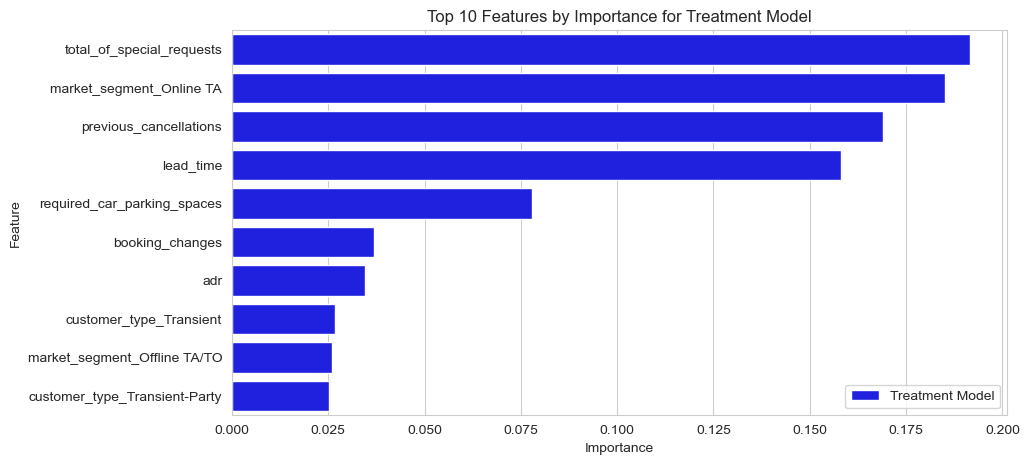

In [54]:
# plot top 10 features for each
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance_df.nlargest(10, 'Treatment Model Importance'), x='Treatment Model Importance', y='Feature', color='blue', label='Treatment Model')
plt.title('Top 10 Features by Importance for Treatment Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend()
plt.show()


- This is for those with deposit (i.e. Treatment group)

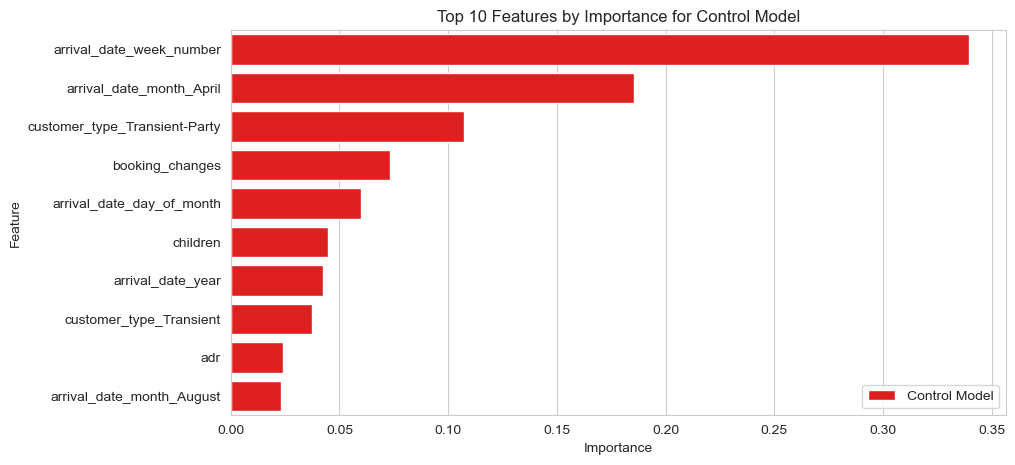

In [55]:
plt.figure(figsize=(10, 5))

sns.barplot(data=feature_importance_df.nlargest(10, 'Control Model Importance'), x='Control Model Importance', y='Feature', color='red', label='Control Model')
plt.title('Top 10 Features by Importance for Control Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend()
plt.show()

**The above two graphs highlight the T-Learner's effectiveness:**

The **T-Learner** excels with **separate models** for the treatment group (TG) and control group (CG), ensuring robust analysis despite **lack of attribute similarity**. This distinction allows for precise learning of outcome variable responsiveness across diverse groups. **S-learner**, in contrast, uses a single feature for differentiation, potentially oversimplifying complex dynamics. 

Moreover, the T-learner's adaptability to **small sample sizes** in TG or CG underscores its utility, circumventing the **S-learner's limitations** with unbalanced data, thereby offering **deeper insights** into customer characteristics and behavior.

### Marketing Strategy

**Targeted Deposit Policies**

The analysis has revealed that the effect of deposit requirements on cancellation rates varies across different customer segments and booking conditions. This insight can be leveraged to develop targeted deposit policies that cater to the specific needs and sensitivities of different customer groups. By tailoring deposit requirements to the characteristics of various market segments, hotels can optimize their booking and cancellation policies to enhance customer satisfaction and revenue stability.

#### **Segmentation Based on CATE/ITE**


In [56]:
# identify the customer segments that are most sensitive to the change in deposit type

# if cate_estimates_test value is larger than -0.5, then the customer is not sensitive to the change in deposit type
sensitive_customers = X_test[cate_estimates_test <= -0.5]
not_sensitive_customers = X_test[cate_estimates_test > -0.5]

In [57]:
sensitive_customers.shape

(14098, 59)

In [58]:
not_sensitive_customers.shape

(6472, 59)

When customers are making reservations, avoiding a deposit for those **not sensitive** to it can potentially **increase reservations**, as hesitation often arises with deposit requirements. 

The logic: if customer behavior (on cancellation) remains unchanged by deposit requests, **eliminating the deposit** could enhance reservation likelihood. However, validating the impact of **not requiring a deposit** on reservation rates necessitates further experimentation, especially since the dataset only includes data for completed reservations, omitting those deterred by deposit requirements. 

This gap highlights the need for **additional research** to confirm the theory.